# Scatter matrix

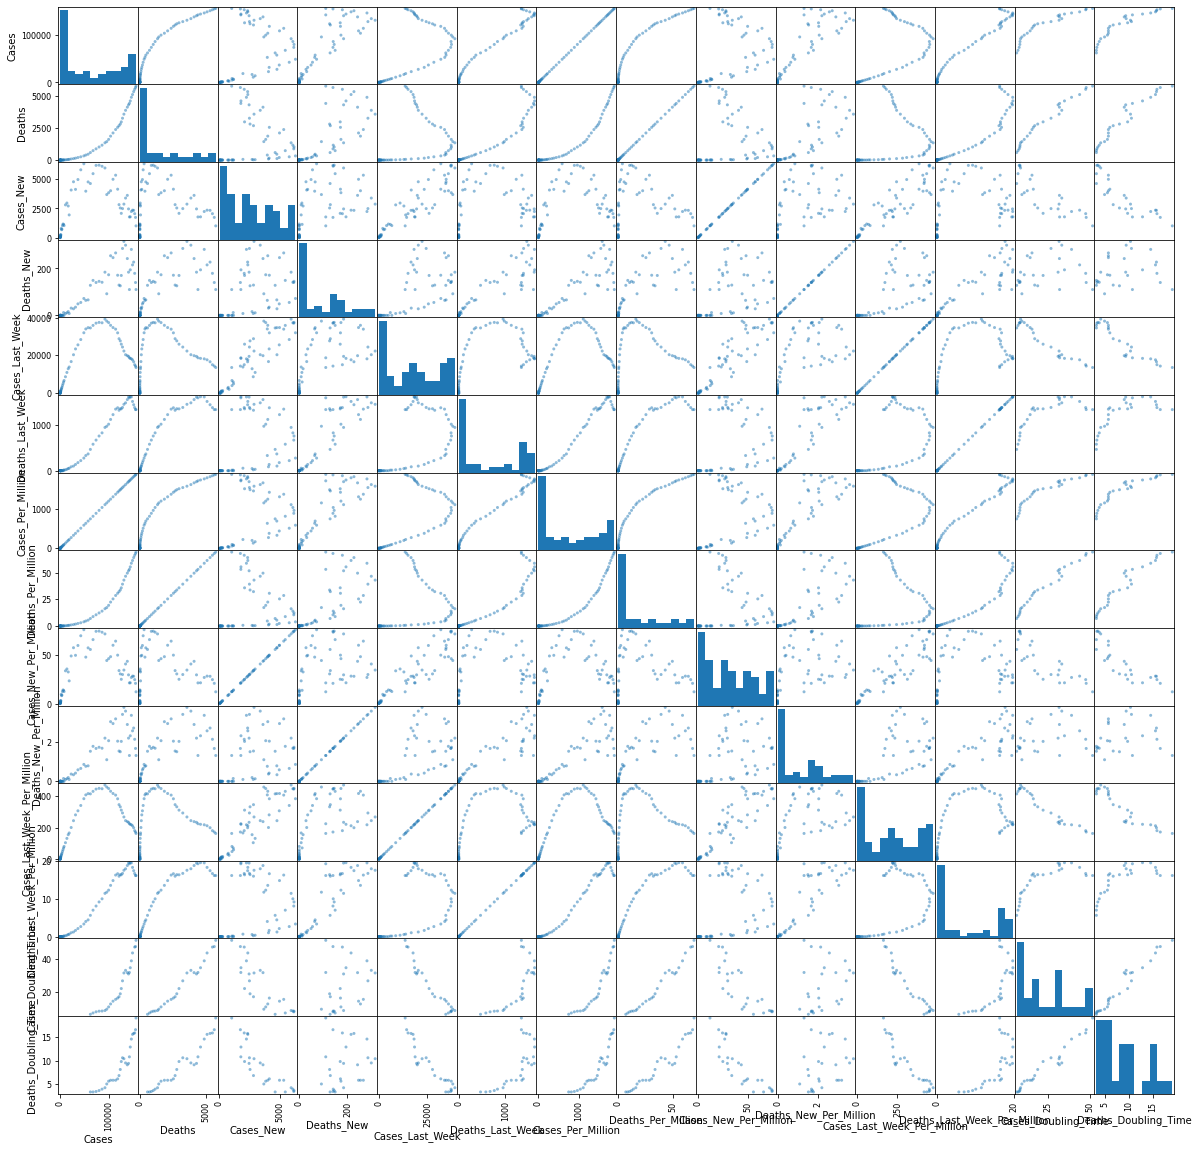

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

area = 'DE-total'
de = entorb.to_dataframe(area)
ax = pd.plotting.scatter_matrix(de, figsize=(20,20))

# R²

In [2]:
corr = de.corr()**2
corr.style.background_gradient(cmap='Blues')

,Cases,Deaths,Cases_New,Deaths_New,Cases_Last_Week,Deaths_Last_Week,Cases_Per_Million,Deaths_Per_Million,Cases_New_Per_Million,Deaths_New_Per_Million,Cases_Last_Week_Per_Million,Deaths_Last_Week_Per_Million,Cases_Doubling_Time,Deaths_Doubling_Time
Cases,1.000000,0.877734,0.154539,0.793742,0.362189,0.970410,1.000000,0.877735,0.154541,0.793729,0.362189,0.970409,0.858496,0.829442
Deaths,0.877734,1.000000,0.010689,0.602779,0.088054,0.853012,0.877734,1.000000,0.010690,0.602767,0.088054,0.853013,0.969384,0.928810
Cases_New,0.154539,0.010689,1.000000,0.233659,0.826055,0.110431,0.154539,0.010689,1.000000,0.233612,0.826055,0.110432,0.682081,0.734960
Deaths_New,0.793742,0.602779,0.233659,1.000000,0.410248,0.825035,0.793742,0.602782,0.233662,1.000000,0.410248,0.825034,0.043846,0.028305
Cases_Last_Week,0.362189,0.088054,0.826055,0.410248,1.000000,0.310992,0.362189,0.088055,0.826058,0.410227,1.000000,0.310989,0.940073,0.871736
Deaths_Last_Week,0.970410,0.853012,0.110431,0.825035,0.310992,1.000000,0.970410,0.853014,0.110433,0.825037,0.310992,1.000000,0.553394,0.495479
Cases_Per_Million,1.000000,0.877734,0.154539,0.793742,0.362189,0.970410,1.000000,0.877735,0.154541,0.793729,0.362189,0.970409,0.858496,0.829442
Deaths_Per_Million,0.877735,1.000000,0.010689,0.602782,0.088055,0.853014,0.877735,1.000000,0.010690,0.602770,0.088055,0.853014,0.969383,0.928808
Cases_New_Per_Million,0.154541,0.010690,1.000000,0.233662,0.826058,0.110433,0.154541,0.010690,1.000000,0.233615,0.826058,0.110434,0.682084,0.734962
Deaths_New_Per_Million,0.793729,0.602767,0.233612,1.000000,0.410227,0.825037,0.793729,0.602770,0.233615,1.000000,0.410228,0.825036,0.043836,0.028294


# Deaths formula:

Deaths = 
               2
3.174e-07 Cases - 0.01427 Cases + 84.36


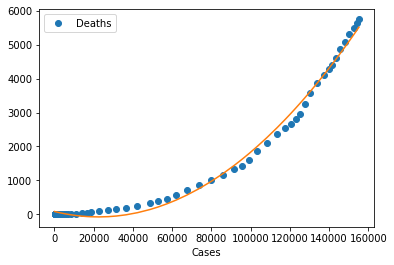

In [3]:
import numpy as np
coefs = np.polyfit(x=de['Cases'], y=de['Deaths'], deg=2)
de.plot(kind='line', x='Cases', y='Deaths', linestyle='', marker='o')
poly = np.poly1d(coefs, variable='Cases')
plt.plot(de['Cases'], poly(de['Cases']))
print("Deaths = ")
print(poly)

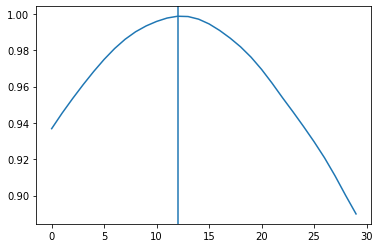

In [4]:
import numpy as np

conv = lagged_correlation = pd.DataFrame.from_dict(
    {'Cases VS Deaths': [de['Cases'].fillna(method='pad').corr(de['Deaths'].fillna(method='pad').shift(-t)) 
                         for t in range(int(0.5 * min([len(de['Cases'].dropna()), len(de['Deaths'].dropna())])))]})

fig, ax = plt.subplots()
ax.plot(conv)
ax.axvline(np.argmax(conv))